#Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from collections import deque
import time
import copy
from tensorflow.keras import layers, regularizers
from copy import deepcopy

#Define Class Rectangle

In [ ]:
class Rectangle:
    def __init__(self, width, height, id_num=None):
        self.width = width
        self.height = height
        self.id = id_num
        self.x = 0
        self.y = 0
        self.rotated = False

    def get_area(self):
        return self.width * self.height

    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated
        return self

    def can_fit(self, width, height):
        return (self.width <= width and self.height <= height) or (self.height <= width and self.width <= height)

    def __str__(self):
        return f"Rectangle(id={self.id}, width={self.width}, height={self.height}, position=({self.x}, {self.y}), rotated={self.rotated})"

#Define Cutting Stock Environment

In [ ]:
class CuttingStockEnvironment:
    def __init__(self, stock_width, stock_height, rectangles, max_sheets=5):
        self.stock_width = stock_width
        self.stock_height = stock_height
        self.original_rectangles = rectangles
        self.rectangles = []
        self.max_sheets = max_sheets

        self.sheets = []
        self.current_sheet_idx = 0
        self.total_area_used = 0
        self.total_sheet_area = 0

        # Untuk representasi state
        self.grid_size = 10  # Resolusi grid untuk representasi state
        self.width_grid = self.stock_width // self.grid_size
        self.height_grid = self.stock_height // self.grid_size

        # Tambahan untuk penempatan berdempetan
        self.valid_positions = []

    def reset(self):
        self.rectangles = [Rectangle(r.width, r.height, r.id) for r in self.original_rectangles]
        self.rectangles = sorted(self.rectangles, key=lambda r: r.get_area(), reverse=True)

        self.sheets = []
        self.current_sheet_idx = 0
        self.total_area_used = 0
        self.total_sheet_area = 0

        # Inisialisasi sheet pertama
        self._initialize_new_sheet()

        # Representasi state: [layout sheet saat ini, ukuran potongan berikutnya]
        return self._get_state()

    def _initialize_new_sheet(self):
        new_sheet = np.zeros((self.stock_height, self.stock_width), dtype=np.int32)
        self.sheets.append(new_sheet)
        self.current_sheet_idx = len(self.sheets) - 1
        self.total_sheet_area += self.stock_width * self.stock_height

        # Inisialisasi posisi valid - awalnya hanya pojok kiri bawah (0,0)
        self.valid_positions = [(0, 0)]

    def _update_valid_positions(self, rect_x, rect_y, rect_width, rect_height):
        # Hapus posisi yang digunakan
        if (rect_x, rect_y) in self.valid_positions:
            self.valid_positions.remove((rect_x, rect_y))

        # Tambahkan posisi baru di kanan dan atas dari potongan yang ditempatkan
        right_pos = (rect_x + rect_width, rect_y)
        top_pos = (rect_x, rect_y + rect_height)

        # Tambahkan posisi hanya jika masih dalam batas dan belum ada
        if right_pos not in self.valid_positions and right_pos[0] < self.stock_width:
            self.valid_positions.append(right_pos)

        if top_pos not in self.valid_positions and top_pos[1] < self.stock_height:
            self.valid_positions.append(top_pos)

    def _get_state(self):
        # Downsampling layout sheet saat ini ke grid untuk representasi state
        current_sheet = self.sheets[self.current_sheet_idx]
        grid_layout = np.zeros((self.height_grid, self.width_grid), dtype=np.float32)

        for h in range(self.height_grid):
            for w in range(self.width_grid):
                h_start = h * self.grid_size
                w_start = w * self.grid_size
                # Area dalam grid ini sudah terisi jika ada nilai positif dalam area sheet asli
                grid_layout[h, w] = np.any(current_sheet[h_start:h_start+self.grid_size,
                                                      w_start:w_start+self.grid_size] > 0)

        # Flatten grid untuk input neural network
        flattened_grid = grid_layout.flatten()

        # Tambahkan informasi potongan berikutnya jika masih ada
        if len(self.rectangles) > 0:
            next_rect = self.rectangles[0]
            next_rect_info = np.array([
                next_rect.width / self.stock_width,
                next_rect.height / self.stock_height
            ], dtype=np.float32)
        else:
            next_rect_info = np.zeros(2, dtype=np.float32)

        # Posisi valid saat ini - representasikan sebagai bitmap
        valid_pos_map = np.zeros((self.height_grid, self.width_grid), dtype=np.float32)
        for x, y in self.valid_positions:
            grid_x, grid_y = x // self.grid_size, y // self.grid_size
            if 0 <= grid_x < self.width_grid and 0 <= grid_y < self.height_grid:
                valid_pos_map[grid_y, grid_x] = 1.0

        # Gabungkan informasi layout, posisi valid, dan potongan berikutnya
        state = np.concatenate([flattened_grid, valid_pos_map.flatten(), next_rect_info])
        return state

    def can_place_rectangle(self, x, y, width, height):
        if x + width > self.stock_width or y + height > self.stock_height:
            return False

        current_sheet = self.sheets[self.current_sheet_idx]
        area_to_check = current_sheet[y:y+height, x:x+width]
        return not np.any(area_to_check > 0)

    def step(self, action):
        if len(self.rectangles) == 0:
            return self._get_state(), 0, True, {"message": "No more rectangles"}

        # Aksi:
        # action[0] = indeks posisi valid
        # action[1] = rotasi (0 atau 1)
        pos_idx, rotate = action

        # Jika tidak ada posisi valid
        if not self.valid_positions:
            if self.current_sheet_idx < self.max_sheets - 1:
                self._initialize_new_sheet()
                return self._get_state(), -0.5, False, {"message": "New sheet initialized"}
            else:
                return self._get_state(), -1, True, {"message": "No valid positions left and max sheets reached"}

        # Jika indeks posisi tidak valid
        if pos_idx >= len(self.valid_positions):
            return self._get_state(), -1, False, {"message": "Invalid position index"}

        # Ambil posisi dari daftar posisi valid
        x, y = self.valid_positions[pos_idx]

        # Potongan berikutnya
        rect = self.rectangles[0]

        # Rotate jika diminta
        if rotate == 1:
            rect.rotate()

        # Cek apakah potongan bisa ditempatkan
        if not self.can_place_rectangle(x, y, rect.width, rect.height):
            # Kembalikan rotasi jika diputar
            if rotate == 1:
                rect.rotate()

            # Penempatan tidak valid - beri reward negatif
            return self._get_state(), -0.5, False, {"message": "Invalid placement"}

        # Penempatan valid - tambahkan potongan ke sheet
        rect.x = x
        rect.y = y
        current_sheet = self.sheets[self.current_sheet_idx]
        current_sheet[y:y+rect.height, x:x+rect.width] = rect.id
        self.total_area_used += rect.get_area()

        # Update posisi valid
        self._update_valid_positions(x, y, rect.width, rect.height)

        # Hapus potongan dari daftar
        self.rectangles.pop(0)

        # Jika tidak ada lagi potongan, episode selesai
        done = len(self.rectangles) == 0

        # Jika masih ada potongan tapi tidak ada posisi valid di sheet ini, buat sheet baru
        if not done and not any(self.can_place_rectangle(x, y, self.rectangles[0].width, self.rectangles[0].height) or
                              self.can_place_rectangle(x, y, self.rectangles[0].height, self.rectangles[0].width)
                              for x, y in self.valid_positions):
            if self.current_sheet_idx < self.max_sheets - 1:
                self._initialize_new_sheet()

        # Hitung reward - berikan bonus untuk penempatan berdempetan
        # Kita bisa mengukur "berdemeptan" dengan melihat jumlah sisi yang bersentuhan
        touching_edges_bonus = self._calculate_touching_edges(rect.x, rect.y, rect.width, rect.height)

        # Reward berdasarkan utilisasi material dan bonus berdempetan
        current_utilization = self.total_area_used / self.total_sheet_area
        reward = current_utilization + touching_edges_bonus * 0.1

        # Jika episode selesai, tambahkan bonus reward berdasarkan utilisasi akhir
        if done:
            final_utilization = self.total_area_used / self.total_sheet_area
            reward += final_utilization * 2  # Bonus untuk utilisasi akhir

        return self._get_state(), reward, done, {
            "utilization": current_utilization,
            "touching_edges": touching_edges_bonus
        }

    def _calculate_touching_edges(self, x, y, width, height):
        """Hitung jumlah sisi yang bersentuhan dengan potongan lain atau batas sheet"""
        current_sheet = self.sheets[self.current_sheet_idx]
        touching_count = 0

        # Cek kiri
        if x == 0:
            touching_count += height  # Sentuh batas sheet
        else:
            left_edge = current_sheet[y:y+height, x-1]
            touching_count += np.sum(left_edge > 0)

        # Cek kanan
        if x + width == self.stock_width:
            touching_count += height  # Sentuh batas sheet
        else:
            right_edge = current_sheet[y:y+height, x+width]
            touching_count += np.sum(right_edge > 0)

        # Cek bawah
        if y == 0:
            touching_count += width  # Sentuh batas sheet
        else:
            bottom_edge = current_sheet[y-1, x:x+width]
            touching_count += np.sum(bottom_edge > 0)

        # Cek atas
        if y + height == self.stock_height:
            touching_count += width  # Sentuh batas sheet
        else:
            top_edge = current_sheet[y+height, x:x+width]
            touching_count += np.sum(top_edge > 0)

        # Normalisasi dengan keliling
        perimeter = 2 * (width + height)
        return touching_count / perimeter

    def render(self):
        fig, axs = plt.subplots(1, len(self.sheets), figsize=(5 * len(self.sheets), 5))
        if len(self.sheets) == 1:
            axs = [axs]

        for i, sheet in enumerate(self.sheets):
            ax = axs[i]
            ax.set_xlim(0, self.stock_width)
            ax.set_ylim(0, self.stock_height)
            ax.set_aspect('equal')

            # Gambar sheet
            sheet_rect = patches.Rectangle((0, 0), self.stock_width, self.stock_height,
                                          linewidth=2, edgecolor='black', facecolor='none')
            ax.add_patch(sheet_rect)

            # Gambar potongan
            color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

            # Temukan semua ID unik dalam sheet
            unique_ids = np.unique(sheet)
            unique_ids = unique_ids[unique_ids > 0]  # Hilangkan background (0)

            for id_num in unique_ids:
                mask = sheet == id_num
                y_indices, x_indices = np.where(mask)
                y_min, x_min = np.min(y_indices), np.min(x_indices)
                height = np.max(y_indices) - y_min + 1
                width = np.max(x_indices) - x_min + 1

                color_idx = (id_num - 1) % len(color_cycle)
                rect_patch = patches.Rectangle((x_min, y_min), width, height,
                                              linewidth=1, edgecolor='black',
                                              facecolor=color_cycle[color_idx], alpha=0.7)
                ax.add_patch(rect_patch)

                # Tambahkan label
                ax.text(x_min + width/2, y_min + height/2, f"ID: {id_num}\n{width}x{height}",
                       ha='center', va='center', fontsize=8)

            ax.set_title(f'Sheet {i+1}')

        # Judul utama
        utilization = self.total_area_used / self.total_sheet_area
        waste_percentage = 100 * (1 - utilization)
        plt.suptitle(f'Cutting Stock Layout (ML-based)\n'
                    f'Utilization: {utilization:.2f} ({waste_percentage:.2f}% waste)')

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

In [ ]:
def get_valid_actions(env):
    """Mengembalikan daftar aksi valid berdasarkan state saat ini"""
    valid_actions = []

    if len(env.rectangles) == 0 or not env.valid_positions:
        return valid_actions

    next_rect = env.rectangles[0]

    # Cek kedua orientasi dan semua posisi valid
    for pos_idx, (x, y) in enumerate(env.valid_positions):
        # Tanpa rotasi
        if env.can_place_rectangle(x, y, next_rect.width, next_rect.height):
            valid_actions.append((pos_idx, 0))  # (pos_idx, no_rotation)

        # Dengan rotasi
        if env.can_place_rectangle(x, y, next_rect.height, next_rect.width):
            valid_actions.append((pos_idx, 1))  # (pos_idx, with_rotation)

    return valid_actions

def action_to_tuple(action, max_positions):
    """Convert action index to (pos_idx, rotation)"""
    rotation = action % 2
    pos_idx = action // 2
    return (pos_idx % max_positions, rotation)

#Train Model

##Heuristik Bottom-Left

In [ ]:
def bottom_left_packing(stock_width, stock_height, rectangles):
    env = CuttingStockEnvironment(stock_width, stock_height, rectangles)
    env.reset()

    while len(env.rectangles) > 0:
        # Potongan berikutnya
        rect = env.rectangles[0]
        placed = False

        # Coba berbagai posisi valid
        for pos_idx, (x, y) in enumerate(env.valid_positions):
            # Coba tanpa rotasi
            if env.can_place_rectangle(x, y, rect.width, rect.height):
                action = (pos_idx, 0)
                env.step(action)
                placed = True
                break

            # Coba dengan rotasi
            if env.can_place_rectangle(x, y, rect.height, rect.width):
                action = (pos_idx, 1)
                env.step(action)
                placed = True
                break

        # Jika tidak bisa ditempatkan di sheet saat ini, buat sheet baru
        if not placed:
            if env.current_sheet_idx < env.max_sheets - 1:
                env._initialize_new_sheet()
            else:
                print(f"Tidak dapat menempatkan semua potongan. {len(env.rectangles)} potongan tersisa.")
                break

    return env

##Deep Q-Network Agent

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = keras.Sequential()
        model.add(layers.Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, valid_actions=None):
        if valid_actions is None or not valid_actions:
            # Jika tidak ada aksi valid, pilih random
            return np.random.randint(0, self.action_size)

        if np.random.rand() <= self.epsilon:
            # Pilih random dari aksi valid selama eksplorasi
            return random.choice(valid_actions)

        # Jika tidak eksplorasi, pilih aksi terbaik dari aksi valid
        act_values = self.model.predict(np.array([state]), verbose=0)[0]
        # Filter hanya aksi valid
        valid_act_values = {a: act_values[a] for a in valid_actions}
        return max(valid_act_values, key=valid_act_values.get)

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states, targets = [], []

        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_model.predict(np.array([next_state]), verbose=0)[0])

            target_f = self.model.predict(np.array([state]), verbose=0)[0]
            target_f[action] = target

            states.append(state)
            targets.append(target_f)

        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save(name)

def train_cutting_stock_rl(stock_width, stock_height, rectangles, episodes=500):
    env = CuttingStockEnvironment(stock_width, stock_height, rectangles)

    # Ukuran state: grid_layout + valid_positions + next_rect_info
    state_size = env.width_grid * env.height_grid * 2 + 2

    # Ukuran action space: (max_positions * 2) - worst case semua posisi valid
    max_positions = env.stock_width * env.stock_height // (env.grid_size * env.grid_size)
    action_size = max_positions * 2

    agent = DQNAgent(state_size, action_size)
    batch_size = 32

    best_utilization = 0
    best_env = None

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while True:
            # Dapatkan aksi valid
            valid_actions_tuples = get_valid_actions(env)

            if not valid_actions_tuples:
                # Tidak ada aksi valid, episode selesai
                break

            # Konversi aksi tuple ke indeks
            valid_actions = []
            for pos_idx, rotation in valid_actions_tuples:
                action_idx = pos_idx * 2 + rotation
                valid_actions.append(action_idx)

            # Pilih aksi
            action_idx = agent.act(state, valid_actions)

            # Konversi ke format aksi untuk env
            action = action_to_tuple(action_idx, max_positions)

            # Jalankan aksi
            next_state, reward, done, info = env.step(action)

            # Simpan ke memory
            agent.remember(state, action_idx, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps += 1

            if done or steps > 100:  # Batasi jumlah langkah per episode
                break

        # Latih agent dengan replay
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        # Update target model
        if e % 10 == 0:
            agent.update_target_model()

        # Simpan jika mendapatkan hasil terbaik
        utilization = env.total_area_used / env.total_sheet_area
        if utilization > best_utilization:
            best_utilization = utilization
            best_env = copy.deepcopy(env)

        print(f"Episode: {e+1}/{episodes}, Steps: {steps}, Reward: {total_reward:.2f}, "
              f"Utilization: {utilization:.2f}, Epsilon: {agent.epsilon:.2f}")

    print(f"Training completed. Best utilization: {best_utilization:.2f}")
    return best_env, agent

##Advanced Deep Q-Network Agent

In [ ]:
class AdvancedDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters
        self.learning_rate = 0.0005
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.memory = []
        self.memory_size = 10000

        # Advanced neural network architecture
        self.model = self._build_advanced_model()
        self.target_model = self._build_advanced_model()
        self.update_target_model()

    def _build_advanced_model(self):
        """
        More sophisticated neural network architecture with:
        - Increased depth
        - Regularization
        - Batch normalization
        - Residual connections
        """
        inputs = keras.Input(shape=(self.state_size,))

        # Residual block function
        def residual_block(x, units, activation='relu'):
          """Residual block dengan penanganan perubahan dimensi"""
          shortcut = x

          # Jika dimensi tidak sama, tambahkan projection layer ke shortcut
          if shortcut.shape[-1] != units:
              shortcut = layers.Dense(units, activation=None,
                                    kernel_regularizer=regularizers.l2(0.001))(shortcut)
              shortcut = layers.BatchNormalization()(shortcut)

          # Main path
          x = layers.Dense(units, activation=None,
                          kernel_regularizer=regularizers.l2(0.001))(x)
          x = layers.BatchNormalization()(x)
          x = layers.Activation(activation)(x)

          x = layers.Dense(units, activation=None,
                          kernel_regularizer=regularizers.l2(0.001))(x)
          x = layers.BatchNormalization()(x)

          # Gabungkan shortcut dan main path
          x = layers.Add()([shortcut, x])
          x = layers.Activation(activation)(x)
          return x

        # Lapisan awal
        x = layers.Dense(128, activation='relu',
                        kernel_regularizer=regularizers.l2(0.001))(inputs)
        x = layers.BatchNormalization()(x)

        # Residual blocks dengan unit yang sama atau projection
        x = residual_block(x, 128)  # Unit tetap 128
        x = residual_block(x, 128)
        x = residual_block(x, 64)   # Unit berubah ke 64 (shortcut diprojek)

        # Lapisan akhir
        x = layers.Dense(64, activation='relu',
                        kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)

        outputs = layers.Dense(self.action_size, activation='linear')(x)

        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss=keras.losses.Huber(),
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005))
        return model

        return model

    def update_target_model(self):
        """Soft update of target model"""
        tau = 0.001  # Soft update parameter
        target_weights = self.target_model.get_weights()
        online_weights = self.model.get_weights()

        for i in range(len(target_weights)):
            target_weights[i] = tau * online_weights[i] + (1 - tau) * target_weights[i]

        self.target_model.set_weights(target_weights)

    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        experience = (state, action, reward, next_state, done)

        if len(self.memory) >= self.memory_size:
            self.memory.pop(0)

        self.memory.append(experience)

    def act(self, state, valid_actions=None):
        """Select action with epsilon-greedy strategy"""
        if valid_actions is None or not valid_actions:
            return np.random.randint(0, self.action_size)

        # Exploration
        if np.random.rand() <= self.epsilon:
            return random.choice(valid_actions)

        # Exploitation
        act_values = self.model.predict(np.array([state]), verbose=0)[0]
        valid_act_values = {a: act_values[a] for a in valid_actions}

        return max(valid_act_values, key=valid_act_values.get)

    def replay(self, batch_size):
        """Experience replay with prioritized sampling"""
        if len(self.memory) < batch_size:
            return

        # Random batch sampling
        minibatch = random.sample(self.memory, batch_size)

        states, targets = [], []

        for state, action, reward, next_state, done in minibatch:
            target = reward

            if not done:
                # Double DQN target calculation
                next_act = np.argmax(self.model.predict(np.array([next_state]), verbose=0)[0])
                target_next_q_values = self.target_model.predict(np.array([next_state]), verbose=0)[0]
                target = reward + self.gamma * target_next_q_values[next_act]

            target_f = self.model.predict(np.array([state]), verbose=0)[0]
            target_f[action] = target

            states.append(state)
            targets.append(target_f)

        # Fit with reduced verbosity
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

        # Decay exploration
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_advanced_cutting_stock_rl(stock_width, stock_height, rectangles, episodes=10):
    """Advanced training function with improved tracking"""
    from copy import deepcopy

    env = CuttingStockEnvironment(stock_width, stock_height, rectangles)

    # State and action space configuration
    state_size = env.width_grid * env.height_grid * 2 + 2
    max_positions = env.stock_width * env.stock_height // (env.grid_size * env.grid_size)
    action_size = max_positions * 2

    # Initialize advanced agent
    agent = AdvancedDQNAgent(state_size, action_size)
    batch_size = 64  # Increased batch size

    # Tracking variables
    best_utilization = 0
    best_env = None
    utilization_history = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while True:
            # Get valid actions
            valid_actions_tuples = get_valid_actions(env)

            if not valid_actions_tuples:
                break

            # Convert actions to indices
            valid_actions = []
            for pos_idx, rotation in valid_actions_tuples:
                action_idx = pos_idx * 2 + rotation
                valid_actions.append(action_idx)

            # Select and execute action
            action_idx = agent.act(state, valid_actions)
            action = action_to_tuple(action_idx, max_positions)

            next_state, reward, done, _ = env.step(action)

            # Store experience
            agent.remember(state, action_idx, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps += 1

            if done or steps > 200:
                break

        # Replay and update
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

        # Update target model periodically
        if e % 5 == 0:
            agent.update_target_model()

        # Track best environment
        utilization = env.total_area_used / env.total_sheet_area
        utilization_history.append(utilization)

        if utilization > best_utilization:
            best_utilization = utilization
            best_env = deepcopy(env)

        # Print progress
        print(f"Episode: {e+1}/{episodes}, "
              f"Steps: {steps}, "
              f"Reward: {total_reward:.2f}, "
              f"Utilization: {utilization:.2f}, "
              f"Epsilon: {agent.epsilon:.2f}")

    print(f"Training completed. Best utilization: {best_utilization:.2f}")
    return best_env, agent, utilization_history

##Actor-Critic Method

In [ ]:
class ActorCriticAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters
        self.learning_rate_actor = 0.0001
        self.learning_rate_critic = 0.001
        self.gamma = 0.99

        # Actor and Critic networks
        self.actor = self._build_actor_network()
        self.critic = self._build_critic_network()

    def _build_actor_network(self):
        """Build probabilistic policy network"""
        inputs = layers.Input(shape=(self.state_size,))

        # Gunakan initializer yang stabil dan regularisasi
        x = layers.Dense(128, activation='relu',
                        kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizers.l2(0.001))(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)  # Regularisasi tambahan

        x = layers.Dense(64, activation='relu',
                        kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)

        outputs = layers.Dense(self.action_size, activation='softmax',
                              kernel_initializer='glorot_uniform')(x)

        model = keras.Model(inputs=inputs, outputs=outputs)

        # Optimizer dengan gradient clipping
        optimizer = keras.optimizers.Adam(
            learning_rate=self.learning_rate_actor,
            clipvalue=0.5
        )
        model.compile(optimizer=optimizer)
        return model

    def _build_critic_network(self):
        """Build value function network"""
        inputs = layers.Input(shape=(self.state_size,))
        x = layers.Dense(128, activation='relu')(inputs)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(1, activation='linear')(x)

        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate_critic),
                      loss='mse')
        return model

    def act(self, state, valid_actions=None):
        """Select action based on actor policy"""
        if valid_actions is None or not valid_actions:
            return np.random.randint(0, self.action_size)

        # Predict action probabilities
        probs = self.actor.predict(np.array([state]), verbose=0)[0]

        # Handle NaN in predictions
        if np.isnan(probs).any():
            return np.random.choice(valid_actions)

        # Filter probabilities to valid actions
        valid_probs = {a: probs[a] for a in valid_actions}

        # Normalize probabilities
        total = sum(valid_probs.values())

        if total <= 0:
            prob_list = [1.0 / len(valid_actions) for _ in valid_actions]
        else:
            prob_list = [valid_probs[a] / total for a in valid_actions]
            prob_array = np.array(prob_list, dtype=np.float64)
            prob_array /= prob_array.sum()  # Normalisasi ulang
            prob_list = prob_array.tolist()

        # Handle residual NaN/Inf
        if np.isnan(prob_list).any() or np.isinf(prob_list).any():
            return np.random.choice(valid_actions)

        return np.random.choice(valid_actions, p=prob_list)

    def train(self, state, action, reward, next_state, done):
        """Jointly train actor and critic"""
        # Compute TD error
        target = reward
        if not done:
            next_value = self.critic.predict(np.array([next_state]), verbose=0)[0][0]
            target += self.gamma * next_value

        # Handle NaN in target
        if np.isnan(target):
            return

        # Train critic
        self.critic.fit(np.array([state]), np.array([[target]]), verbose=0)

        # Compute TD error untuk actor
        current_value = self.critic.predict(np.array([state]), verbose=0)[0][0]
        td_error = target - current_value

        # Skip update jika TD error NaN
        if np.isnan(td_error):
            return

        # Train actor dengan gradient clipping
        with tf.GradientTape() as tape:
            action_probs = self.actor(np.array([state]))
            action_mask = tf.one_hot([action], self.action_size)
            log_prob = tf.math.log(tf.reduce_sum(action_probs * action_mask, axis=1))
            actor_loss = -log_prob * td_error

        # Hitung gradient dengan clipping
        grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        grads = [tf.clip_by_value(g, -0.5, 0.5) for g in grads]  # Clipping manual
        self.actor.optimizer.apply_gradients(zip(grads, self.actor.trainable_variables))

def train_actor_critic_cutting_stock(stock_width, stock_height, rectangles, episodes=1000):
    """Actor-Critic training function"""

    env = CuttingStockEnvironment(stock_width, stock_height, rectangles)

    # State and action space configuration
    state_size = env.width_grid * env.height_grid * 2 + 2
    max_positions = env.stock_width * env.stock_height // (env.grid_size * env.grid_size)
    action_size = max_positions * 2

    # Initialize Actor-Critic agent
    agent = ActorCriticAgent(state_size, action_size)

    # Tracking variables
    best_utilization = 0
    best_env = None
    utilization_history = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while True:
            # Get valid actions
            valid_actions_tuples = get_valid_actions(env)

            if not valid_actions_tuples:
                break

            # Convert actions to indices
            valid_actions = []
            for pos_idx, rotation in valid_actions_tuples:
                action_idx = pos_idx * 2 + rotation
                valid_actions.append(action_idx)

            # Select and execute action
            action_idx = agent.act(state, valid_actions)
            action = action_to_tuple(action_idx, max_positions)

            next_state, reward, done, _ = env.step(action)

            # Train agent
            agent.train(state, action_idx, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps += 1

            if done or steps > 200:
                break

        # Track best environment
        utilization = env.total_area_used / env.total_sheet_area
        utilization_history.append(utilization)

        if utilization > best_utilization:
            best_utilization = utilization
            best_env = deepcopy(env)

        # Print progress
        print(f"Episode: {e+1}/{episodes}, "
              f"Steps: {steps}, "
              f"Reward: {total_reward:.2f}, "
              f"Utilization: {utilization:.2f}")

    print(f"Training completed. Best utilization: {best_utilization:.2f}")
    return best_env, agent, utilization_history

##Policy Gradient

In [ ]:
class PolicyGradientAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters
        self.learning_rate = 0.001
        self.gamma = 0.99  # Discount factor

        # Memory for storing episode experiences
        self.states = []
        self.actions = []
        self.rewards = []

        # Policy network
        self.model = self._build_policy_network()

    def _build_policy_network(self):
        """Build a policy network with probabilistic output"""
        model = keras.Sequential([
            layers.Dense(128, activation='relu',
                        input_shape=(self.state_size,),
                        kernel_initializer='glorot_uniform'),
            layers.Dense(64, activation='relu',
                        kernel_initializer='glorot_uniform'),
            layers.Dense(self.action_size, activation='softmax',
                        kernel_initializer='glorot_uniform')
        ])

        optimizer = keras.optimizers.Adam(
            learning_rate=self.learning_rate,
            clipvalue=0.5  # Gradient clipping
        )
        model.compile(optimizer=optimizer, loss='categorical_crossentropy')
        return model

    def remember(self, state, action, reward):
        """Store episode memories"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def act(self, state, valid_actions=None):
        """Select action based on policy probability distribution"""
        if valid_actions is None or not valid_actions:
            return np.random.randint(0, self.action_size)

        # Predict action probabilities
        probs = self.model.predict(np.array([state]), verbose=0)[0]

        # Handle NaN in model predictions
        if np.isnan(probs).any():
            return np.random.choice(valid_actions)

        # Filter probabilities to valid actions
        valid_probs = {a: probs[a] for a in valid_actions}

        # Normalize probabilities
        total = sum(valid_probs.values())

        if total <= 0:
            prob_list = [1.0 / len(valid_actions) for _ in valid_actions]
        else:
            prob_list = [valid_probs[a] / total for a in valid_actions]
            prob_array = np.array(prob_list, dtype=np.float64)
            prob_array /= prob_array.sum()  # Normalisasi ulang
            prob_list = prob_array.tolist()

        # Handle residual NaN/Inf
        if np.isnan(prob_list).any() or np.isinf(prob_list).any():
            return np.random.choice(valid_actions)

        return np.random.choice(valid_actions, p=prob_list)

    def discount_rewards(self, rewards):
        """Compute discounted rewards"""
        discounted_rewards = np.zeros_like(rewards, dtype=float)
        running_total = 0

        for t in reversed(range(len(rewards))):
            running_total = running_total * self.gamma + rewards[t]
            discounted_rewards[t] = running_total

        # Normalize rewards
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)
        return discounted_rewards

    def train(self):
        """Update policy network based on episode experiences"""
        discounted_rewards = self.discount_rewards(self.rewards)

        # Prepare training data
        states = np.array(self.states)
        actions = np.array(self.actions)

        # One-hot encode actions
        action_masks = tf.one_hot(actions, self.action_size)

        # Train using custom training loop for policy gradient
        with tf.GradientTape() as tape:
            action_probs = self.model(states)
            log_probs = tf.math.log(tf.reduce_sum(action_probs * action_masks, axis=1))
            loss = -tf.reduce_mean(log_probs * discounted_rewards)

        # Compute and apply gradients
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        # Reset memories
        self.states, self.actions, self.rewards = [], [], []

def train_policy_gradient_cutting_stock(stock_width, stock_height, rectangles, episodes):
    """Policy Gradient training function"""
    from copy import deepcopy

    env = CuttingStockEnvironment(stock_width, stock_height, rectangles)

    # State and action space configuration
    state_size = env.width_grid * env.height_grid * 2 + 2
    max_positions = env.stock_width * env.stock_height // (env.grid_size * env.grid_size)
    action_size = max_positions * 2

    # Initialize Policy Gradient agent
    agent = PolicyGradientAgent(state_size, action_size)

    # Tracking variables
    best_utilization = 0
    best_env = None
    utilization_history = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while True:
            # Get valid actions
            valid_actions_tuples = get_valid_actions(env)

            if not valid_actions_tuples:
                break

            # Convert actions to indices
            valid_actions = []
            for pos_idx, rotation in valid_actions_tuples:
                action_idx = pos_idx * 2 + rotation
                valid_actions.append(action_idx)

            # Select and execute action
            action_idx = agent.act(state, valid_actions)
            action = action_to_tuple(action_idx, max_positions)

            next_state, reward, done, _ = env.step(action)

            # Store experience
            agent.remember(state, action_idx, reward)

            state = next_state
            total_reward += reward
            steps += 1

            if done or steps > 200:
                break

        # Train after each episode
        agent.train()

        # Track best environment
        utilization = env.total_area_used / env.total_sheet_area
        utilization_history.append(utilization)

        if utilization > best_utilization:
            best_utilization = utilization
            best_env = deepcopy(env)

        # Print progress
        print(f"Episode: {e+1}/{episodes}, "
              f"Steps: {steps}, "
              f"Reward: {total_reward:.2f}, "
              f"Utilization: {utilization:.2f}")

    print(f"Training completed. Best utilization: {best_utilization:.2f}")
    return best_env, agent, utilization_history

#Main Code

===== MENGGUNAKAN HEURISTIK BOTTOM-LEFT =====


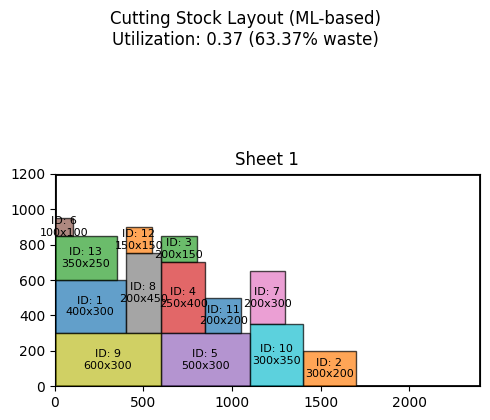

Jumlah sheet: 1
Utilisasi material: 0.37 (63.37% waste)
Waktu komputasi: 3.86 detik

===== MENGGUNAKAN REINFORCEMENT LEARNING DQN =====
Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/1, Steps: 13, Reward: 4.60, Utilization: 0.37, Epsilon: 1.00
Training completed. Best utilization: 0.37


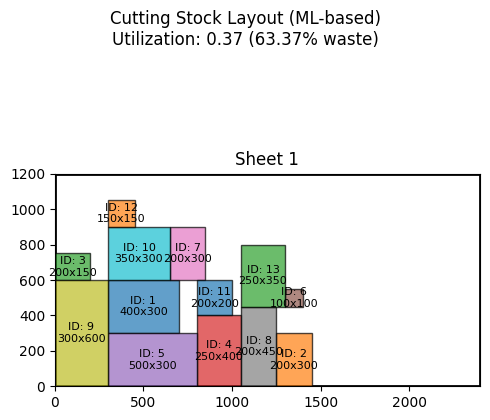

Jumlah sheet: 1
Utilisasi material: 0.37 (63.37% waste)
Waktu training: 2.97 detik
Model DQN tersimpan.

===== MENGGUNAKAN ADVANCED DQN =====
Training Advanced DQN model...
Episode: 1/1, Steps: 13, Reward: 4.64, Utilization: 0.37, Epsilon: 1.00
Training completed. Best utilization: 0.37


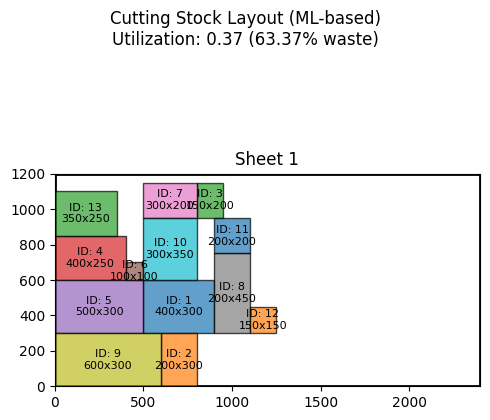

Jumlah sheet: 1
Utilisasi material: 0.37 (63.37% waste)
Waktu training: 4.41 detik


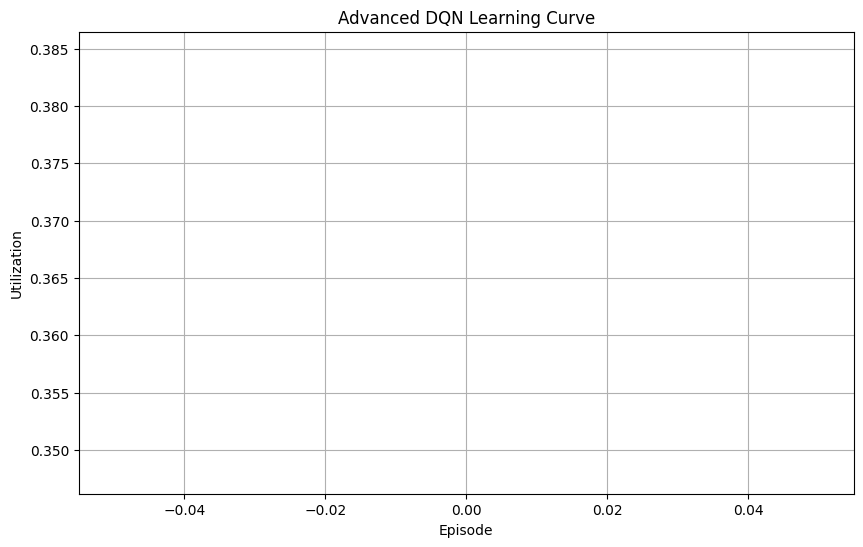


===== MENGGUNAKAN ACTOR-CRITIC METHOD =====
Training Actor-Critic model...
Episode: 1/1, Steps: 13, Reward: 4.66, Utilization: 0.37
Training completed. Best utilization: 0.37


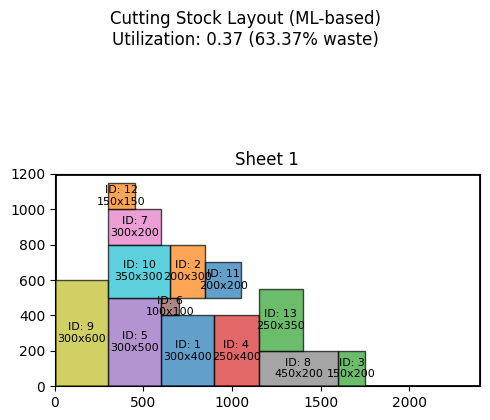

Jumlah sheet: 1
Utilisasi material: 0.37 (63.37% waste)
Waktu training: 13.86 detik


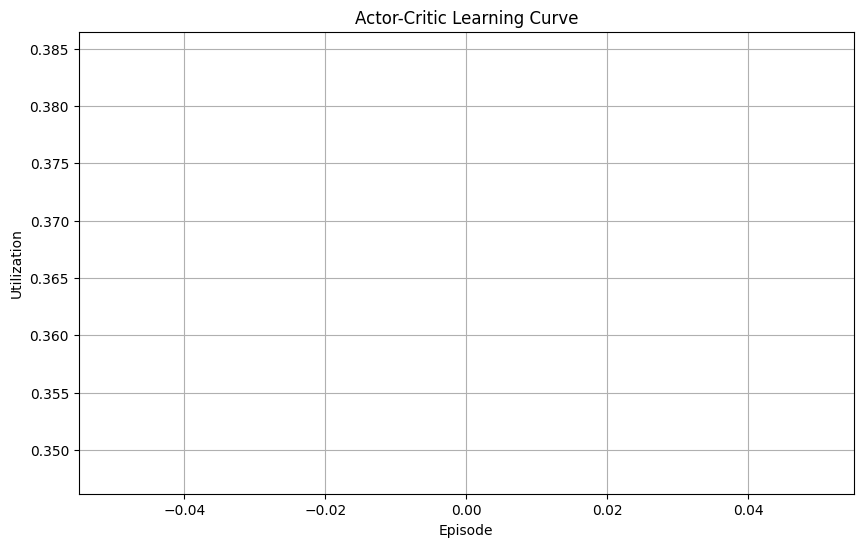


===== MENGGUNAKAN POLICY GRADIENT =====
Training Policy Gradient model...
Episode: 1/1, Steps: 13, Reward: 4.60, Utilization: 0.37
Training completed. Best utilization: 0.37


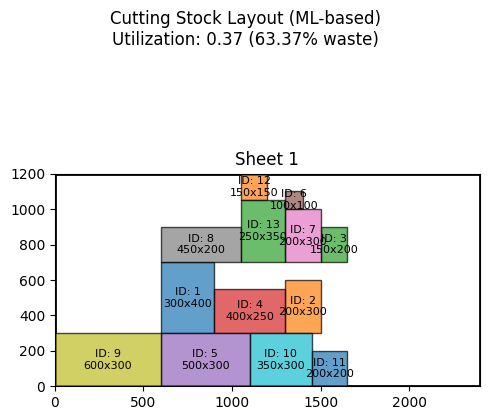

Jumlah sheet: 1
Utilisasi material: 0.37 (63.37% waste)
Waktu training: 5.71 detik


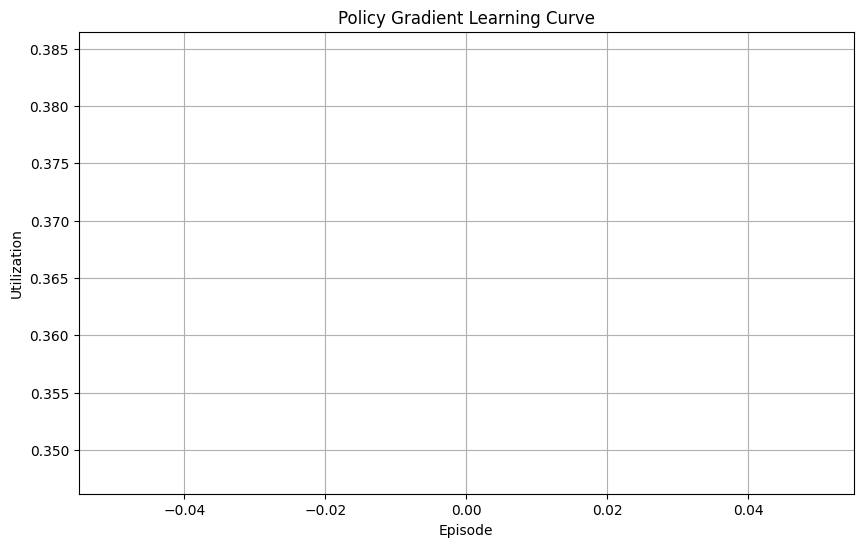


===== PERBANDINGAN SEMUA METODE =====

Tabel Perbandingan:
Metode               | Utilisasi       | Waste (%)       | Jumlah Sheet    | Waktu (s)      
--------------------------------------------------------------------------------
Bottom-Left          | 0.3663         | 63.37%         | 1               | 3.86
DQN                  | 0.3663         | 63.37%         | 1               | 2.97
Advanced DQN         | 0.3663         | 63.37%         | 1               | 4.41
Actor-Critic         | 0.3663         | 63.37%         | 1               | 13.86
Policy Gradient      | 0.3663         | 63.37%         | 1               | 5.71


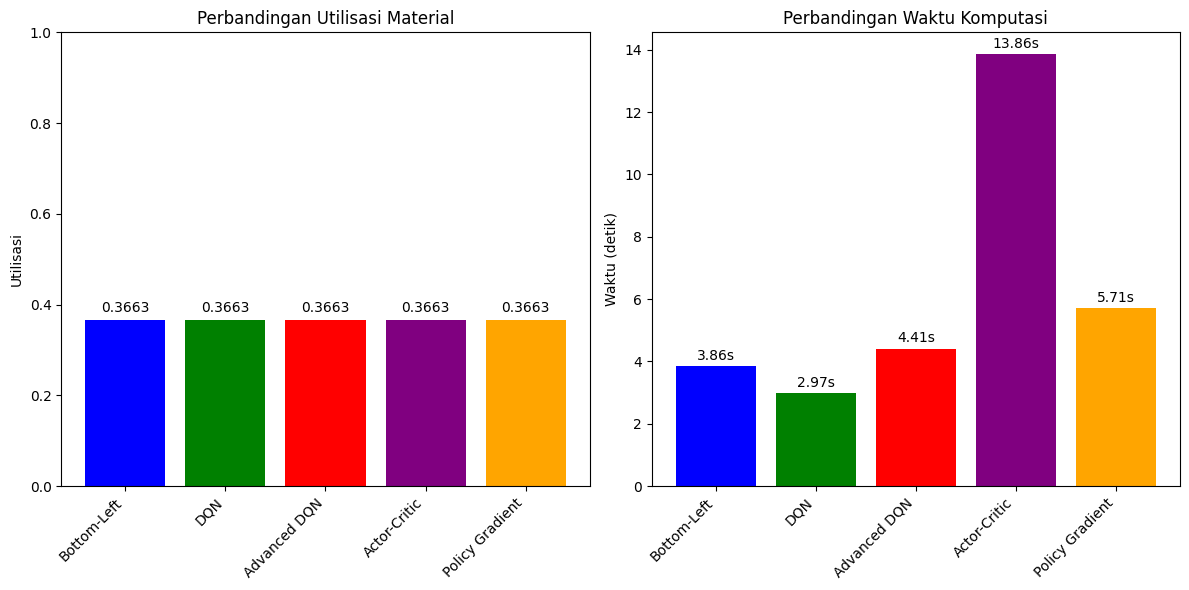

In [ ]:
# Contoh penggunaan dengan heuristik
if __name__ == "__main__":
    # Ukuran stock sheet
    stock_width = 2400
    stock_height = 1200

    # Daftar potongan yang dibutuhkan
    rectangle_sizes = [
        (400, 300, 1),
        (300, 200, 2),
        (200, 150, 3),
        (250, 400, 4),
        (500, 300, 5),
        (100, 100, 6),
        (200, 300, 7),
        (450, 200, 8),
        (600, 300, 9),
        (300, 350, 10),
        (200, 200, 11),
        (150, 150, 12),
        (350, 250, 13),
        (400, 400, 14),
        (250, 250, 15),
        (500, 500, 16),
        (100, 200, 17),
        (300, 400, 18),
        (200, 300, 19),
        (400, 200, 20),
        (350, 350, 21),
        (200, 400, 22),
        (150, 250, 23),
        (300, 500, 24),
        (450, 450, 25)
    ]

    # Buat objek Rectangle
    rectangles = [Rectangle(width, height, id_num) for width, height, id_num in rectangle_sizes]

    print("===== MENGGUNAKAN HEURISTIK BOTTOM-LEFT =====")
    start_time = time.time()
    bl_env = bottom_left_packing(stock_width, stock_height, rectangles)
    bl_time = time.time() - start_time

    # Tampilkan hasil
    bl_env.render()
    utilization = bl_env.total_area_used / bl_env.total_sheet_area
    waste_percentage = 100 * (1 - utilization)
    print(f"Jumlah sheet: {len(bl_env.sheets)}")
    print(f"Utilisasi material: {utilization:.2f} ({waste_percentage:.2f}% waste)")
    print(f"Waktu komputasi: {bl_time:.2f} detik")

    print("\n===== MENGGUNAKAN REINFORCEMENT LEARNING DQN =====")
    print("Training model...")
    # Latih model RL dengan lebih banyak episode untuk hasil yang lebih baik
    rectangles = [Rectangle(width, height, id_num) for width, height, id_num in rectangle_sizes]
    start_time = time.time()
    best_env, agent = train_cutting_stock_rl(stock_width, stock_height, rectangles, episodes=1)
    training_time = time.time() - start_time

    # Visualisasikan hasil terbaik
    best_env.render()

    # Cetak informasi hasil
    utilization = best_env.total_area_used / best_env.total_sheet_area
    waste_percentage = 100 * (1 - utilization)
    print(f"Jumlah sheet: {len(best_env.sheets)}")
    print(f"Utilisasi material: {utilization:.2f} ({waste_percentage:.2f}% waste)")
    print(f"Waktu training: {training_time:.2f} detik")

    # Simpan model
    agent.save("cutting_stock_improved_dqn.h5")
    print("Model DQN tersimpan.")

    # ==================== TAMBAHAN KODE UNTUK MODEL LAINNYA ====================

    print("\n===== MENGGUNAKAN ADVANCED DQN =====")
    print("Training Advanced DQN model...")
    rectangles = [Rectangle(width, height, id_num) for width, height, id_num in rectangle_sizes]
    start_time = time.time()
    best_adv_env, adv_agent, adv_history = train_advanced_cutting_stock_rl(stock_width, stock_height, rectangles, episodes=1)
    adv_training_time = time.time() - start_time

    # Visualisasikan hasil terbaik
    best_adv_env.render()

    # Cetak informasi hasil
    adv_utilization = best_adv_env.total_area_used / best_adv_env.total_sheet_area
    adv_waste_percentage = 100 * (1 - adv_utilization)
    print(f"Jumlah sheet: {len(best_adv_env.sheets)}")
    print(f"Utilisasi material: {adv_utilization:.2f} ({adv_waste_percentage:.2f}% waste)")
    print(f"Waktu training: {adv_training_time:.2f} detik")

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(adv_history)
    plt.title('Advanced DQN Learning Curve')
    plt.xlabel('Episode')
    plt.ylabel('Utilization')
    plt.grid(True)
    plt.savefig('advanced_dqn_learning_curve.png')
    plt.show()

    print("\n===== MENGGUNAKAN ACTOR-CRITIC METHOD =====")
    print("Training Actor-Critic model...")
    rectangles = [Rectangle(width, height, id_num) for width, height, id_num in rectangle_sizes]
    start_time = time.time()
    best_ac_env, ac_agent, ac_history = train_actor_critic_cutting_stock(stock_width, stock_height, rectangles, episodes=1)
    ac_training_time = time.time() - start_time

    # Visualisasikan hasil terbaik
    best_ac_env.render()

    # Cetak informasi hasil
    ac_utilization = best_ac_env.total_area_used / best_ac_env.total_sheet_area
    ac_waste_percentage = 100 * (1 - ac_utilization)
    print(f"Jumlah sheet: {len(best_ac_env.sheets)}")
    print(f"Utilisasi material: {ac_utilization:.2f} ({ac_waste_percentage:.2f}% waste)")
    print(f"Waktu training: {ac_training_time:.2f} detik")

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(ac_history)
    plt.title('Actor-Critic Learning Curve')
    plt.xlabel('Episode')
    plt.ylabel('Utilization')
    plt.grid(True)
    plt.savefig('actor_critic_learning_curve.png')
    plt.show()

    print("\n===== MENGGUNAKAN POLICY GRADIENT =====")
    print("Training Policy Gradient model...")
    rectangles = [Rectangle(width, height, id_num) for width, height, id_num in rectangle_sizes]
    start_time = time.time()
    best_pg_env, pg_agent, pg_history = train_policy_gradient_cutting_stock(stock_width, stock_height, rectangles, episodes=1)
    pg_training_time = time.time() - start_time

    # Visualisasikan hasil terbaik
    best_pg_env.render()

    # Cetak informasi hasil
    pg_utilization = best_pg_env.total_area_used / best_pg_env.total_sheet_area
    pg_waste_percentage = 100 * (1 - pg_utilization)
    print(f"Jumlah sheet: {len(best_pg_env.sheets)}")
    print(f"Utilisasi material: {pg_utilization:.2f} ({pg_waste_percentage:.2f}% waste)")
    print(f"Waktu training: {pg_training_time:.2f} detik")

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(pg_history)
    plt.title('Policy Gradient Learning Curve')
    plt.xlabel('Episode')
    plt.ylabel('Utilization')
    plt.grid(True)
    plt.savefig('policy_gradient_learning_curve.png')
    plt.show()

    # Perbandingan semua metode
    print("\n===== PERBANDINGAN SEMUA METODE =====")
    methods = ['Bottom-Left', 'DQN', 'Advanced DQN', 'Actor-Critic', 'Policy Gradient']
    utilizations = [
        bl_env.total_area_used / bl_env.total_sheet_area,
        best_env.total_area_used / best_env.total_sheet_area,
        best_adv_env.total_area_used / best_adv_env.total_sheet_area,
        best_ac_env.total_area_used / best_ac_env.total_sheet_area,
        best_pg_env.total_area_used / best_pg_env.total_sheet_area
    ]
    times = [bl_time, training_time, adv_training_time, ac_training_time, pg_training_time]
    n_sheets = [len(bl_env.sheets), len(best_env.sheets), len(best_adv_env.sheets),
                len(best_ac_env.sheets), len(best_pg_env.sheets)]

    # Tabel perbandingan
    print("\nTabel Perbandingan:")
    print("=" * 80)
    print(f"{'Metode':<20} | {'Utilisasi':<15} | {'Waste (%)':<15} | {'Jumlah Sheet':<15} | {'Waktu (s)':<15}")
    print("-" * 80)
    for i, method in enumerate(methods):
        waste = 100 * (1 - utilizations[i])
        print(f"{method:<20} | {utilizations[i]:.4f}         | {waste:.2f}%         | {n_sheets[i]:<15} | {times[i]:.2f}")
    print("=" * 80)

    # Plot perbandingan utilisasi
    plt.figure(figsize=(12, 6))

    # Plot utilisasi
    plt.subplot(1, 2, 1)
    bars = plt.bar(methods, utilizations, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title('Perbandingan Utilisasi Material')
    plt.ylabel('Utilisasi')
    plt.ylim(0, 1)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    plt.xticks(rotation=45, ha='right')

    # Plot waktu komputasi
    plt.subplot(1, 2, 2)
    bars = plt.bar(methods, times, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.title('Perbandingan Waktu Komputasi')
    plt.ylabel('Waktu (detik)')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}s', ha='center', va='bottom')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig('perbandingan_metode.png')
    plt.show()

#Inference Model

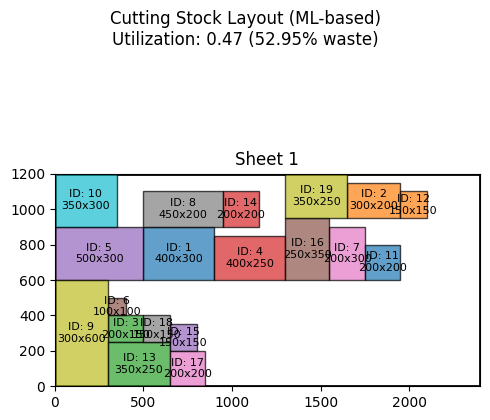

Sheets used: 1
Material Utilization: 0.47 (52.95% waste)


In [ ]:
class Rectangle:
    def __init__(self, width, height, id_num=None):
        self.width = width
        self.height = height
        self.id = id_num
        self.x = 0
        self.y = 0
        self.rotated = False

    def get_area(self):
        return self.width * self.height

    def rotate(self):
        self.width, self.height = self.height, self.width
        self.rotated = not self.rotated
        return self

    def can_fit(self, width, height):
        return (self.width <= width and self.height <= height) or (self.height <= width and self.width <= height)

    def __str__(self):
        return f"Rectangle(id={self.id}, width={self.width}, height={self.height}, position=({self.x}, {self.y}), rotated={self.rotated})"

class CuttingStockEnvironment:
    def __init__(self, stock_width, stock_height, rectangles, max_sheets=5):
        self.stock_width = stock_width
        self.stock_height = stock_height
        self.original_rectangles = rectangles
        self.rectangles = []
        self.max_sheets = max_sheets

        self.sheets = []
        self.current_sheet_idx = 0
        self.total_area_used = 0
        self.total_sheet_area = 0

        # Grid representation parameters
        self.grid_size = 10
        self.width_grid = self.stock_width // self.grid_size
        self.height_grid = self.stock_height // self.grid_size

        self.valid_positions = []

    def reset(self):
        self.rectangles = [Rectangle(r.width, r.height, r.id) for r in self.original_rectangles]
        self.rectangles = sorted(self.rectangles, key=lambda r: r.get_area(), reverse=True)

        self.sheets = []
        self.current_sheet_idx = 0
        self.total_area_used = 0
        self.total_sheet_area = 0

        self._initialize_new_sheet()
        return self._get_state()

    def _initialize_new_sheet(self):
        new_sheet = np.zeros((self.stock_height, self.stock_width), dtype=np.int32)
        self.sheets.append(new_sheet)
        self.current_sheet_idx = len(self.sheets) - 1
        self.total_sheet_area += self.stock_width * self.stock_height
        self.valid_positions = [(0, 0)]

    def _get_state(self):
        current_sheet = self.sheets[self.current_sheet_idx]
        grid_layout = np.zeros((self.height_grid, self.width_grid), dtype=np.float32)

        for h in range(self.height_grid):
            for w in range(self.width_grid):
                h_start = h * self.grid_size
                w_start = w * self.grid_size
                grid_layout[h, w] = np.any(current_sheet[h_start:h_start+self.grid_size,
                                                      w_start:w_start+self.grid_size] > 0)

        flattened_grid = grid_layout.flatten()

        if len(self.rectangles) > 0:
            next_rect = self.rectangles[0]
            next_rect_info = np.array([
                next_rect.width / self.stock_width,
                next_rect.height / self.stock_height
            ], dtype=np.float32)
        else:
            next_rect_info = np.zeros(2, dtype=np.float32)

        valid_pos_map = np.zeros((self.height_grid, self.width_grid), dtype=np.float32)
        for x, y in self.valid_positions:
            grid_x, grid_y = x // self.grid_size, y // self.grid_size
            if 0 <= grid_x < self.width_grid and 0 <= grid_y < self.height_grid:
                valid_pos_map[grid_y, grid_x] = 1.0

        state = np.concatenate([flattened_grid, valid_pos_map.flatten(), next_rect_info])
        return state

    def can_place_rectangle(self, x, y, width, height):
        if x + width > self.stock_width or y + height > self.stock_height:
            return False

        current_sheet = self.sheets[self.current_sheet_idx]
        area_to_check = current_sheet[y:y+height, x:x+width]
        return not np.any(area_to_check > 0)

    def step(self, action):
        if len(self.rectangles) == 0:
            return self._get_state(), 0, True, {"message": "No more rectangles"}

        pos_idx, rotate = action

        if not self.valid_positions:
            if self.current_sheet_idx < self.max_sheets - 1:
                self._initialize_new_sheet()
                return self._get_state(), -0.5, False, {"message": "New sheet initialized"}
            else:
                return self._get_state(), -1, True, {"message": "No valid positions left and max sheets reached"}

        if pos_idx >= len(self.valid_positions):
            return self._get_state(), -1, False, {"message": "Invalid position index"}

        x, y = self.valid_positions[pos_idx]
        rect = self.rectangles[0]

        if rotate == 1:
            rect.rotate()

        if not self.can_place_rectangle(x, y, rect.width, rect.height):
            if rotate == 1:
                rect.rotate()
            return self._get_state(), -0.5, False, {"message": "Invalid placement"}

        rect.x = x
        rect.y = y
        current_sheet = self.sheets[self.current_sheet_idx]
        current_sheet[y:y+rect.height, x:x+rect.width] = rect.id
        self.total_area_used += rect.get_area()

        self._update_valid_positions(x, y, rect.width, rect.height)
        self.rectangles.pop(0)

        done = len(self.rectangles) == 0

        if not done and not any(self.can_place_rectangle(x, y, self.rectangles[0].width, self.rectangles[0].height) or
                              self.can_place_rectangle(x, y, self.rectangles[0].height, self.rectangles[0].width)
                              for x, y in self.valid_positions):
            if self.current_sheet_idx < self.max_sheets - 1:
                self._initialize_new_sheet()

        return self._get_state(), 0, done, {}

    def _update_valid_positions(self, rect_x, rect_y, rect_width, rect_height):
        if (rect_x, rect_y) in self.valid_positions:
            self.valid_positions.remove((rect_x, rect_y))

        right_pos = (rect_x + rect_width, rect_y)
        top_pos = (rect_x, rect_y + rect_height)

        if right_pos not in self.valid_positions and right_pos[0] < self.stock_width:
            self.valid_positions.append(right_pos)

        if top_pos not in self.valid_positions and top_pos[1] < self.stock_height:
            self.valid_positions.append(top_pos)

    def render(self):
        fig, axs = plt.subplots(1, len(self.sheets), figsize=(5 * len(self.sheets), 5))
        if len(self.sheets) == 1:
            axs = [axs]

        for i, sheet in enumerate(self.sheets):
            ax = axs[i]
            ax.set_xlim(0, self.stock_width)
            ax.set_ylim(0, self.stock_height)
            ax.set_aspect('equal')

            sheet_rect = patches.Rectangle((0, 0), self.stock_width, self.stock_height,
                                          linewidth=2, edgecolor='black', facecolor='none')
            ax.add_patch(sheet_rect)

            color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
            unique_ids = np.unique(sheet)
            unique_ids = unique_ids[unique_ids > 0]

            for id_num in unique_ids:
                mask = sheet == id_num
                y_indices, x_indices = np.where(mask)
                y_min, x_min = np.min(y_indices), np.min(x_indices)
                height = np.max(y_indices) - y_min + 1
                width = np.max(x_indices) - x_min + 1

                color_idx = (id_num - 1) % len(color_cycle)
                rect_patch = patches.Rectangle((x_min, y_min), width, height,
                                              linewidth=1, edgecolor='black',
                                              facecolor=color_cycle[color_idx], alpha=0.7)
                ax.add_patch(rect_patch)

                ax.text(x_min + width/2, y_min + height/2, f"ID: {id_num}\n{width}x{height}",
                       ha='center', va='center', fontsize=8)

            ax.set_title(f'Sheet {i+1}')

        utilization = self.total_area_used / self.total_sheet_area
        waste_percentage = 100 * (1 - utilization)
        plt.suptitle(f'Cutting Stock Layout (ML-based)\n'
                    f'Utilization: {utilization:.2f} ({waste_percentage:.2f}% waste)')

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

def get_valid_actions(env):
    valid_actions = []

    if len(env.rectangles) == 0 or not env.valid_positions:
        return valid_actions

    next_rect = env.rectangles[0]

    for pos_idx, (x, y) in enumerate(env.valid_positions):
        if env.can_place_rectangle(x, y, next_rect.width, next_rect.height):
            valid_actions.append((pos_idx, 0))

        if env.can_place_rectangle(x, y, next_rect.height, next_rect.width):
            valid_actions.append((pos_idx, 1))

    return valid_actions

def action_to_tuple(action, max_positions):
    rotation = action % 2
    pos_idx = action // 2
    return (pos_idx % max_positions, rotation)
def run_cutting_stock_inference(model_path, stock_width, stock_height, rectangles, max_steps=100):
    # Load the trained model
    # Import the 'losses' module explicitly
    from tensorflow.keras import losses  # Import losses module

    model = keras.models.load_model(model_path, custom_objects={'mse': losses.mse})  # Specify mse in custom_objects

    # Create environment
    env = CuttingStockEnvironment(stock_width, stock_height, rectangles)

    # Setup parameters
    state_size = env.width_grid * env.height_grid * 2 + 2
    max_positions = env.stock_width * env.stock_height // (env.grid_size * env.grid_size)
    action_size = max_positions * 2

    # Reset environment
    state = env.reset()

    # Run inference
    for step in range(max_steps):
        # Get valid actions
        valid_actions_tuples = get_valid_actions(env)

        if not valid_actions_tuples:
            break

        # Convert actions to indices
        valid_actions = []
        for pos_idx, rotation in valid_actions_tuples:
            action_idx = pos_idx * 2 + rotation
            valid_actions.append(action_idx)

        # Predict action using the loaded model
        act_values = model.predict(np.array([state]), verbose=0)[0]
        valid_act_values = {a: act_values[a] for a in valid_actions}
        action_idx = max(valid_act_values, key=valid_act_values.get)

        # Convert to environment action
        action = action_to_tuple(action_idx, max_positions)

        # Take step
        state, _, done, _ = env.step(action)

        if done:
            break

    # Render results
    env.render()

    # Calculate and print utilization
    utilization = env.total_area_used / env.total_sheet_area
    waste_percentage = 100 * (1 - utilization)
    print(f"Sheets used: {len(env.sheets)}")
    print(f"Material Utilization: {utilization:.2f} ({waste_percentage:.2f}% waste)")

# Example usage
def main():
    # Stock sheet dimensions
    stock_width = 2400
    stock_height = 1200

    # Define rectangles
    rectangle_sizes = [
        (400, 300, 1),
        (300, 200, 2),
        (200, 150, 3),
        (250, 400, 4),
        (500, 300, 5),
        (100, 100, 6),
        (200, 300, 7),
        (450, 200, 8),
        (600, 300, 9),
        (300, 350, 10),
        (200, 200, 11),
        (150, 150, 12),
        (350, 250, 13),
        (200, 200, 14),
        (150, 150, 15),
        (350, 250, 16),
        (200, 200, 17),
        (150, 150, 18),
        (350, 250, 19)
    ]

    # Create rectangle objects
    rectangles = [Rectangle(width, height, id_num) for width, height, id_num in rectangle_sizes]

    # Path to the saved model (adjust this to your .h5 file path)
    model_path = '/content/cutting_stock_improved_dqn.h5'

    # Run inference
    run_cutting_stock_inference(model_path, stock_width, stock_height, rectangles)

if __name__ == "__main__":
    main()